<a href="https://colab.research.google.com/github/bhj8286/dinsosaur_machine_learning_study/blob/main/Chapter4/3_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**XGBoost: 자체적으로 교차 검증, 성능 평가, 피처 중요도 등의 시각화 기능을 갖고 있다.
GBM에서 부족한 여러 가지 성능 향상 기능 보유 -> 대표적으로 조기 중단: 부스팅 반복 횟수에 도달하지 않더라도 예측 오류가 더 이상 개선되지 않으면 반복을 끝까지 수행하지 않고 중지하여 수행 시간 개선**

In [17]:
pip install --upgrade xgboost


In [1]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [2]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


 feature는 모델이 학습하는 입력값, label은 예측하고자 하는 정답값

 예를 들어, 고객의 구매 데이터를 활용해 고객이 제품을 구매할지 여부를 예측하는 모델을 만든다고 하면:

Feature: 나이, 성별, 방문 횟수, 최근 구매 금액 등

Label: 제품 구매 여부 (0: 미구매, 1: 구매)

위스콘신 유방암 데이터 세트의 80%를 학습용으로, 20%를 테스트용으로 추출
그리고 다시 80%의 학습용 데이터에서 90%를 최종 학습용, 10%를 검증용으로 분할
-> 검증용 데이터를 분할하는 이유: XGBoost가 제공하는 기능인 검증 성능 평가와 조기 중단을 수행하기 위해서

In [4]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출.
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [5]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안될 경우 X_train.values로 넘파이 변환.
# 학습, 검증, 테스트용 DMatrix를 생성.
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [6]:
params = { 'max_depth':3,
          'eta': 0.05,
          'objective':'binary:logistic',
          'eval_metric':'logloss'
         }
num_rounds = 400

In [7]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval' 로 명기합니다.
eval_list = [(dtr,'train'),(dval,'eval')] # 또는 eval_list = [(dval,'eval')] 만 명기해도 무방.

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtr , num_boost_round=num_rounds , \
                      early_stopping_rounds=50, evals=eval_list )


[0]	train-logloss:0.62480	eval-logloss:0.63104
[1]	train-logloss:0.58674	eval-logloss:0.60478
[2]	train-logloss:0.55226	eval-logloss:0.58223
[3]	train-logloss:0.52086	eval-logloss:0.56184
[4]	train-logloss:0.49192	eval-logloss:0.54118
[5]	train-logloss:0.46537	eval-logloss:0.52223
[6]	train-logloss:0.44029	eval-logloss:0.50287
[7]	train-logloss:0.41666	eval-logloss:0.48620
[8]	train-logloss:0.39525	eval-logloss:0.46974
[9]	train-logloss:0.37542	eval-logloss:0.45497
[10]	train-logloss:0.35701	eval-logloss:0.44131
[11]	train-logloss:0.33982	eval-logloss:0.43134
[12]	train-logloss:0.32297	eval-logloss:0.41972
[13]	train-logloss:0.30725	eval-logloss:0.40902
[14]	train-logloss:0.29327	eval-logloss:0.39883
[15]	train-logloss:0.27946	eval-logloss:0.38968
[16]	train-logloss:0.26691	eval-logloss:0.38150
[17]	train-logloss:0.25473	eval-logloss:0.37368
[18]	train-logloss:0.24385	eval-logloss:0.36666
[19]	train-logloss:0.23338	eval-logloss:0.35994
[20]	train-logloss:0.22320	eval-logloss:0.35374
[2

In [8]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.938 0.004 0.75  0.049 0.98  1.    0.999 0.999 0.998 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [10]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740,    F1: 0.9740, AUC:0.9965


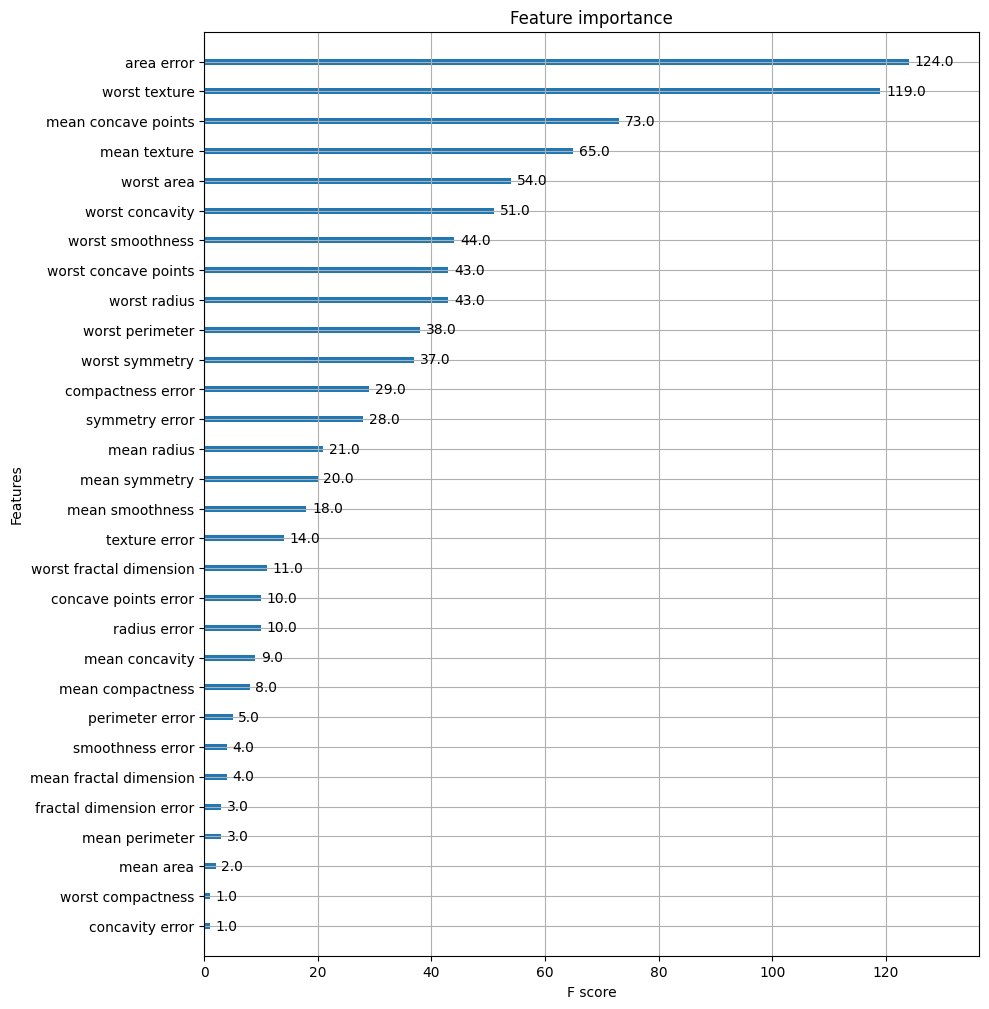

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)
plt.savefig('p239_xgb_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

In [12]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [13]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9947


In [23]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, eval_metric="logloss", early_stopping_rounds=100)

evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, eval_set=evals, verbose=True)


[0]	validation_0-logloss:0.56554
[1]	validation_0-logloss:0.50669
[2]	validation_0-logloss:0.45868
[3]	validation_0-logloss:0.41822
[4]	validation_0-logloss:0.38103
[5]	validation_0-logloss:0.35137
[6]	validation_0-logloss:0.32588
[7]	validation_0-logloss:0.30127
[8]	validation_0-logloss:0.28197
[9]	validation_0-logloss:0.26265
[10]	validation_0-logloss:0.24821
[11]	validation_0-logloss:0.23231
[12]	validation_0-logloss:0.22079
[13]	validation_0-logloss:0.20795
[14]	validation_0-logloss:0.19764
[15]	validation_0-logloss:0.18950
[16]	validation_0-logloss:0.18052
[17]	validation_0-logloss:0.17246
[18]	validation_0-logloss:0.16512
[19]	validation_0-logloss:0.15828
[20]	validation_0-logloss:0.15436
[21]	validation_0-logloss:0.14633
[22]	validation_0-logloss:0.13936
[23]	validation_0-logloss:0.13393
[24]	validation_0-logloss:0.13015
[25]	validation_0-logloss:0.12489
[26]	validation_0-logloss:0.12206
[27]	validation_0-logloss:0.11890
[28]	validation_0-logloss:0.11637
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [26]:
import numpy as np
import xgboost as xgb

# 데이터 변환
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost 모델 설정
params = {
    "objective": "binary:logistic",  # 이진 분류
    "eval_metric": "logloss",
    "learning_rate": 0.1,
    "max_depth": 3
}

evals = [(dtest, "eval")]

# 모델 훈련 (early stopping 적용)
xgb_model = xgb.train(params, dtrain, num_boost_round=400, evals=evals, early_stopping_rounds=100, verbose_eval=True)

# 확률 예측 (0~1 사이의 값)
ws100_pred_proba = xgb_model.predict(dtest)

# 0.5를 기준으로 이진 분류 예측값 생성
ws100_preds = np.where(ws100_pred_proba > 0.5, 1, 0)

# 평가 함수 실행
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)


[0]	eval-logloss:0.56554
[1]	eval-logloss:0.50669
[2]	eval-logloss:0.45868
[3]	eval-logloss:0.41822
[4]	eval-logloss:0.38103
[5]	eval-logloss:0.35137
[6]	eval-logloss:0.32588
[7]	eval-logloss:0.30127
[8]	eval-logloss:0.28197
[9]	eval-logloss:0.26265
[10]	eval-logloss:0.24821
[11]	eval-logloss:0.23231
[12]	eval-logloss:0.22079
[13]	eval-logloss:0.20795
[14]	eval-logloss:0.19764
[15]	eval-logloss:0.18950
[16]	eval-logloss:0.18052
[17]	eval-logloss:0.17246
[18]	eval-logloss:0.16512
[19]	eval-logloss:0.15828
[20]	eval-logloss:0.15436
[21]	eval-logloss:0.14633
[22]	eval-logloss:0.13936
[23]	eval-logloss:0.13393
[24]	eval-logloss:0.13015
[25]	eval-logloss:0.12489
[26]	eval-logloss:0.12206
[27]	eval-logloss:0.11890
[28]	eval-logloss:0.11637
[29]	eval-logloss:0.11293
[30]	eval-logloss:0.11040
[31]	eval-logloss:0.10826
[32]	eval-logloss:0.10452
[33]	eval-logloss:0.10322
[34]	eval-logloss:0.10059
[35]	eval-logloss:0.09869
[36]	eval-logloss:0.09658
[37]	eval-logloss:0.09487
[38]	eval-logloss:0.09

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

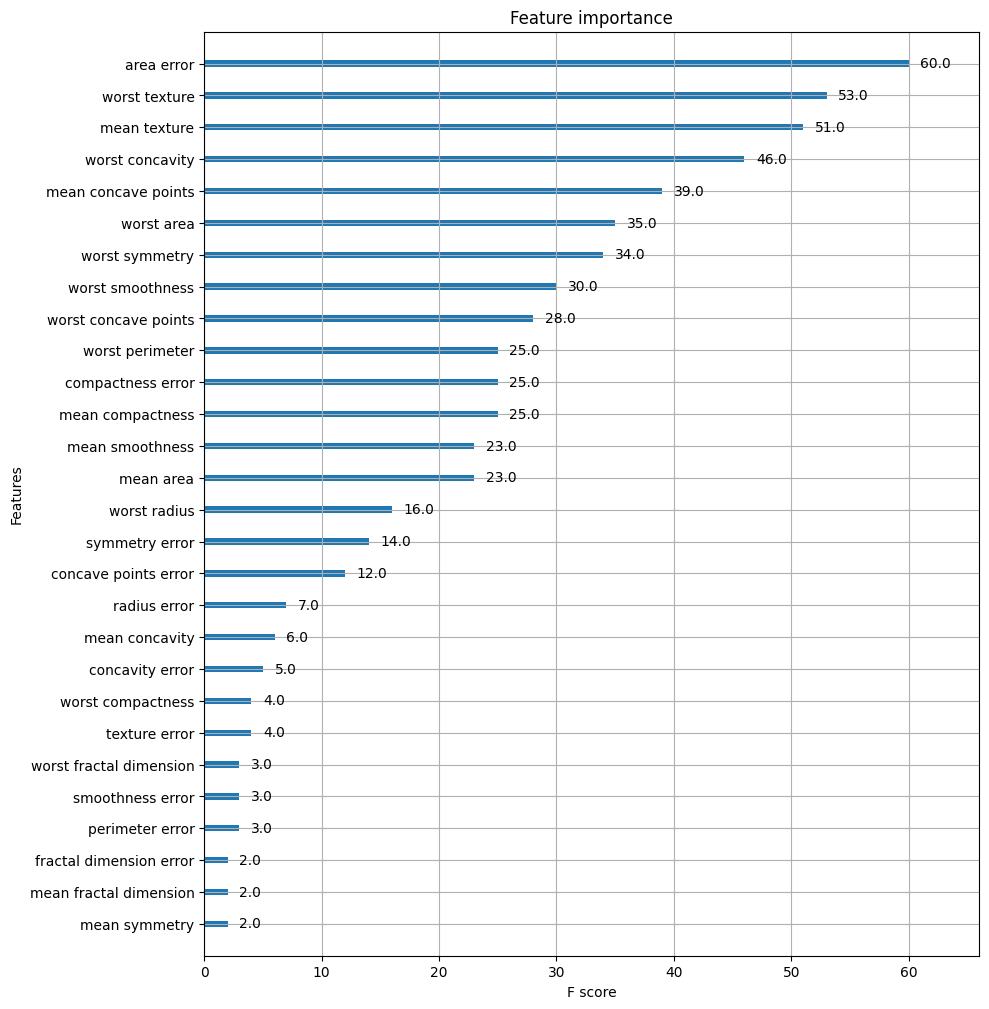

In [27]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방.
plot_importance(xgb_wrapper, ax=ax)